In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt

In [23]:
# loading the dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
    # torchvision.transforms.Normalize(0, 1)]
)
dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform= transform)
train_data = DataLoader(dataset, batch_size=64)

In [24]:
# Vector Quantizer
class VectorQuantizer(nn.Module):
    def __init__(self, num_vectors, vector_dim, loss_constant):
        super().__init__()
        self.num_vectors = num_vectors
        self.vector_dim = vector_dim
        self.beta = loss_constant
        
        # Codebook: (K, D)
        self.embedding = nn.Embedding(num_vectors, vector_dim)
        self.embedding.weight.data.uniform_(-1 / num_vectors, 1 / num_vectors)

    def forward(self, z):
        """
        z: (B, D)
        """
        B, D = z.shape

        # Compute distances (B, K)
        z_flat = z.view(B, 1, D)                      # (B, 1, D)
        embed = self.embedding.weight.view(1, -1, D) # (1, K, D)

        distances = torch.sum((z_flat - embed) ** 2, dim=2)

        # Nearest codebook entry
        indices = torch.argmin(distances, dim=1)     # (B,)
        z_q = self.embedding(indices)                 # (B, D)

        # Losses
        codebook_loss = torch.mean((z_q.detach() - z) ** 2)
        commit_loss = torch.mean((z_q - z.detach()) ** 2)

        q_loss = codebook_loss + self.beta * commit_loss

        # Straight-through estimator
        z_q = z + (z_q - z).detach()

        return z_q, q_loss
        

In [25]:
# VQ-VAE Model

class VQVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=100):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 250),
            nn.ReLU(),
            nn.Linear(250, hidden_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 250),
            nn.ReLU(),
            nn.Linear(250, input_dim),
            nn.Sigmoid()
        )
        
        self.Quantizer = VectorQuantizer(num_vectors= 100, vector_dim=100, loss_constant=0.1)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        z = self.encoder(x)
        quantized, q_loss = self.Quantizer(z)
        x_hat = self.decoder(quantized)
        
        return x_hat, q_loss

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    total_loss = 0
    for batch, _ in train_data:
        batch = batch.to(device)

        optimizer.zero_grad()
        x_hat, q_loss = model(batch)

        recon_loss = criterion(
            x_hat, batch.view(batch.size(0), -1)
        )

        loss = recon_loss + q_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}: Loss = {total_loss / len(train_data):.4f}")


Epoch 0: Loss = 0.0774
Epoch 1: Loss = 0.0568
Epoch 2: Loss = 0.0566
Epoch 3: Loss = 0.0566
Epoch 4: Loss = 0.0564
Epoch 5: Loss = 0.0564
Epoch 6: Loss = 0.0564
Epoch 7: Loss = 0.0564
Epoch 8: Loss = 0.0564
Epoch 9: Loss = 0.0563


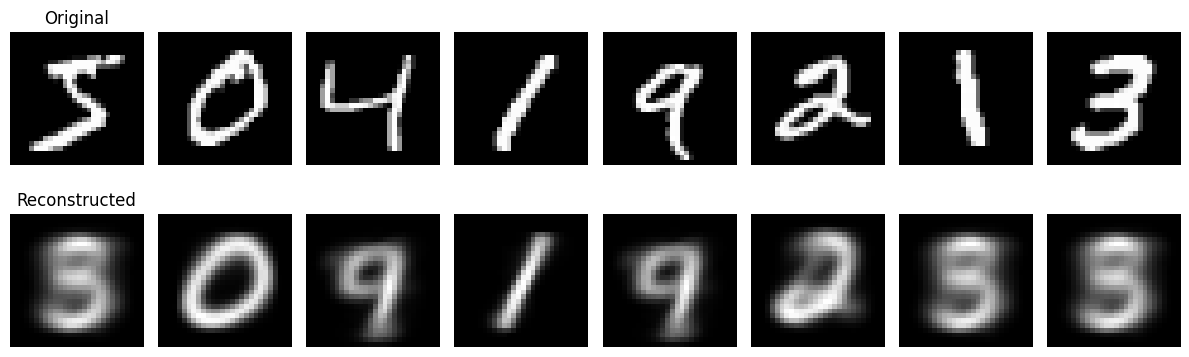

In [27]:
model.eval()


data_iter = iter(train_data)
images, labels = next(data_iter)   # images: (64, 1, 28, 28)
images = images.to(device)

with torch.no_grad():
    recon, q_loss = model(images)
    
    recon_images = recon.view(-1, 1, 28, 28)
    original_images = images
    
n = 8  # number of images to show

plt.figure(figsize=(12, 4))

for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original")

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Reconstructed")

plt.tight_layout()
plt.show()
